# Global Forecasting Models: Independent multi-series forecasting

[Univariate time series forecasting](../introduction-forecasting/introduction-forecasting.html) models a single time series as a linear or nonlinear combination of its lags, using past values of the series to predict its future. Global forecasting, involves building a single predictive model that considers all time series simultaneously. It attempts to capture the core patterns that govern the series, thereby mitigating the potential noise that each series might introduce. This approach is computationally efficient, easy to maintain, and can yield more robust generalizations across time series.

In **independent multi-series forecasting** a single model is trained for all time series, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values. For instance, the sales of products A and B in the same store may not be related, but they follow the same dynamics, that of the store.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_train_matrix_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Internal Forecaster transformation of two time series and an exogenous variable into the matrices needed to train a machine learning model in a multi-series context.</i></font>
</p>

To predict the next *n* steps, the strategy of [recursive multi-step forecasting](../introduction-forecasting/introduction-forecasting.html#recursive-multi-step-forecasting) is applied, with the only difference being that the series name for which to estimate the predictions needs to be indicated.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_prediction_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Diagram of recursive forecasting with multiple independent time series.</i></font>
</p>

Using the <code>ForecasterRecursiveMultiSeries</code> it is possible to easily build machine learning models for independent multi-series forecasting.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Skforecast offers additional approaches to building global forecasting models:

<ul>
    <li>
    <a href="../user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time series with different lengths and different exogenous variables</a>
    </li>
    <li>
    <a href="../user_guides/dependent-multi-series-multivariate-forecasting.html">Global Forecasting Models: Dependent multi-series forecasting (Multivariate forecasting)</a>
    </li>
    <li>
    <a href="../user_guides/forecasting-with-deep-learning-rnn-lstm.html">Global Forecasting Models: Forecasting with Deep Learning</a>
    </li>
</ul>


To learn more about global forecasting models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html">Global Forecasting Models: Multi-series forecasting with Python and skforecast</a>
    </li>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py59-scalable-forecasting-models.html">Scalable Forecasting: Modeling thousand time series with a single global model</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py53-global-forecasting-models">Global Forecasting Models: Comparative Analysis of Single and Multi-Series Forecasting Modeling</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py54-forecasting-with-deep-learning">Forecasting with Deep Learning</a>
    </li>
</ul>

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    grid_search_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.plot import set_dark_theme

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
data.head()

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [3]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00   (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00   (n=170)


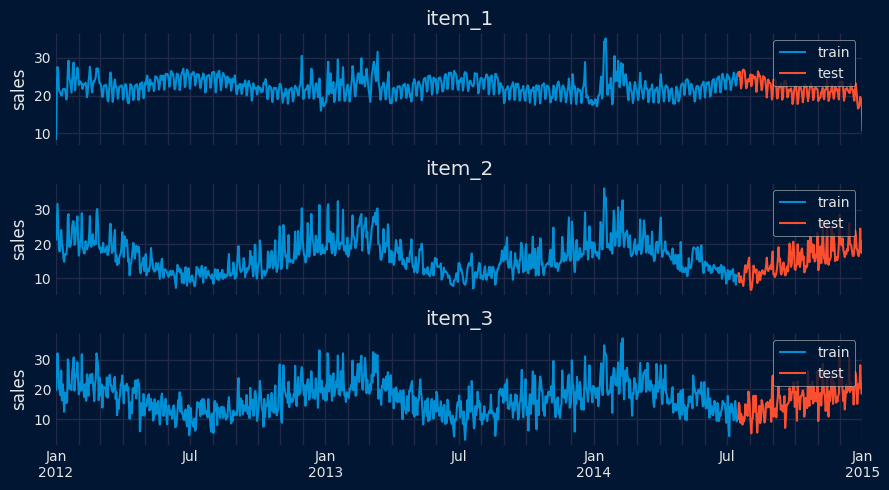

In [4]:
# Plot time series
# ==============================================================================
set_dark_theme()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)
for i, col in enumerate(data.columns):
    data_train[col].plot(ax=axes[i], label='train')
    data_test[col].plot(ax=axes[i], label='test')
    axes[i].set_title(col)
    axes[i].set_ylabel('sales')
    axes[i].set_xlabel('')
    axes[i].legend(loc='upper right')
fig.tight_layout()
plt.show();

## ForecasterRecursiveMultiSeries

In [5]:
# Create and train ForecasterRecursiveMultiSeries
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48]),
                 encoding           = 'ordinal',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

forecaster.fit(series=data_train, store_in_sample_residuals=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_24', 'roll_mean_48'] 
Window size: 48 
Series encoding: ordinal 
Series names (levels): item_1, item_2, item_3 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'item_1': ['2012-01-01', '2014-07-15'], 'item_2': ['2012-01-01', '2014-07-15'],
    'item_3': ['2012-01-01', '2014-07-15'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-01 12:26:56 
Last fit date: 2025-05-01 12:26:56 
Skforecast version: 0.16.0 
Python version: 3.12.9 
Forecaster id: None

Two methods can be use to predict the next n steps: `predict()` or `predict_interval()`. The argument `levels` is used to indicate for which series estimate predictions. If `None` all series will be predicted.

In [6]:
# Predictions and prediction intervals
# ==============================================================================
steps = 24

# Predictions for item_1
predictions_item_1 = forecaster.predict(steps=steps, levels='item_1')
display(predictions_item_1.head(3))

# Interval predictions for item_1 and item_2
predictions_intervals = forecaster.predict_interval(
    steps    = steps,
    levels   = ['item_1', 'item_2'],
    method   = "conformal",
    interval = 0.9
)
display(predictions_intervals.head(3))

,level,pred
2014-07-16,item_1,25.698703
2014-07-17,item_1,25.676440
2014-07-18,item_1,25.269030


,level,pred,lower_bound,upper_bound
2014-07-16,item_1,25.698703,23.630908,27.766498
2014-07-16,item_2,10.469603,8.967505,11.971702
2014-07-17,item_1,25.676440,23.608645,27.744235


## Backtesting multiple series

As in the `predict` method, the `levels` at which [backtesting](../user_guides/backtesting.html) is performed must be indicated. The argument can also be set to `None` to perform backtesting at all levels. In addition to the individual metric(s) for each series, the aggregated value is calculated using the following methods:

+ average: the average (arithmetic mean) of all levels.

+ weighted_average: the average of the metrics weighted by the number of predicted values of each level.

+ pooling: the values of all levels are pooled and then the metric is calculated.

In [7]:
# Backtesting multiple time series
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data_train),
         refit              = True
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data,
    exog                  = None,
    cv                    = cv,
    levels                = None,
    metric                = 'mean_absolute_error',
    add_aggregated_metric = True
)

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/8 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error
0,item_1,1.194108
1,item_2,2.595094
2,item_3,3.316836
3,average,2.368679
4,weighted_average,2.368679
5,pooling,2.368679



Backtest predictions


,level,pred
2014-07-16,item_1,25.698703
2014-07-16,item_2,10.469603
2014-07-16,item_3,11.329472
2014-07-17,item_1,25.676440


## Hyperparameter search and lags selection

The `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` functions in the `model_selection` module allow for lags and hyperparameter optimization. It is performed using the backtesting strategy for validation as in other Forecasters, [see the user guide here](../user_guides/hyperparameter-tuning-and-lags-selection.html), except for the `levels` argument:

`levels`: level(s) at which the forecaster is optimized, for example:

+ If `levels` is a list, the function will search for the lags and hyperparameters that minimize the aggregated error of the predictions of the selected time series. The available aggregation methods are the same as for backtesting (`average`, `weighted_average`, `pooling`). If the `aggregate_metric` argument is a list, all aggregation methods will be calculated for each metric.

+ If `levels = None`, the function will search for the lags and hyperparameters that minimize the aggregated error of the predictions of all time series.

+ If `levels = 'item_1'` (Same as `levels = ['item_1']`), the function will search for the lags and hyperparameters that minimize the error of the `item_1` predictions. The resulting metric will be the one calculated for `item_1`.

The following example shows how to use `grid_search_forecaster_multiseries` to find the best lags and model hyperparameters for all time series (all `levels`).

In [8]:
# Create Forecaster Multi-Series
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )

In [9]:
# Grid search Multi-Series
# ==============================================================================
lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

levels = ['item_1', 'item_2', 'item_3']

cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data_train),
         refit              = False
     )

results = grid_search_forecaster_multiseries(
              forecaster       = forecaster,
              series           = data,
              exog             = None,
              lags_grid        = lags_grid,
              param_grid       = param_grid,
              cv               = cv,
              levels           = levels,
              metric           = 'mean_absolute_error',
              aggregate_metric = 'weighted_average'
          )

results

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 2.2406649526622306
  Levels: ['item_1', 'item_2', 'item_3']



,levels,lags,lags_label,params,mean_absolute_error__weighted_average,max_depth,n_estimators
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",48 lags,"{'max_depth': 7, 'n_estimators': 20}",2.240665,7,20
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",48 lags,"{'max_depth': 3, 'n_estimators': 20}",2.379334,3,20
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",24 lags,"{'max_depth': 7, 'n_estimators': 20}",2.432997,7,20
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",24 lags,"{'max_depth': 3, 'n_estimators': 20}",2.457422,3,20
4,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",48 lags,"{'max_depth': 7, 'n_estimators': 10}",3.048544,7,10
5,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",48 lags,"{'max_depth': 3, 'n_estimators': 10}",3.245697,3,10
6,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",24 lags,"{'max_depth': 3, 'n_estimators': 10}",3.267566,3,10
7,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",24 lags,"{'max_depth': 7, 'n_estimators': 10}",3.331623,7,10


It is also possible to perform a bayesian optimization with `optuna` using the `bayesian_search_forecaster_multiseries` function. For more information about this type of optimization, see the [user guide here](../user_guides/hyperparameter-tuning-and-lags-selection.html#bayesian-search).

In [10]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )

levels = ['item_1', 'item_2', 'item_3']

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [24, 48]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    return search_space

cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data_train),
         refit              = False
     )

results, best_trial = bayesian_search_forecaster_multiseries(
    forecaster       = forecaster,
    series           = data,
    exog             = None,
    search_space     = search_space,
    cv               = cv,
    levels           = levels,
    metric           = 'mean_absolute_error',
    aggregate_metric = ['weighted_average', 'average', 'pooling'],
    n_trials         = 5
)

results.head(4)

  0%|          | 0/5 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}
  Backtesting metric: 2.544932138435008
  Levels: ['item_1', 'item_2', 'item_3']



,levels,lags,params,mean_absolute_error__weighted_average,mean_absolute_error__average,mean_absolute_error__pooling,n_estimators,min_samples_leaf,max_features
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 16, 'min_samples_leaf': 9, 'm...",2.544932,2.544932,2.544932,16,9,log2
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 15, 'min_samples_leaf': 4, 'm...",2.712388,2.712388,2.712388,15,4,sqrt
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 14, 'min_samples_leaf': 8, 'm...",2.824843,2.824843,2.824843,14,8,log2
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 13, 'min_samples_leaf': 3, 'm...",2.984116,2.984116,2.984116,13,3,sqrt


`best_trial` contains information of the trial which achived the best results. See more in [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study).

In [11]:
# Optuna best trial in the study
# ==============================================================================
best_trial

FrozenTrial(number=3, state=1, values=[2.544932138435008], datetime_start=datetime.datetime(2025, 5, 1, 12, 27, 0, 699988), datetime_complete=datetime.datetime(2025, 5, 1, 12, 27, 1, 10170), params={'lags': 48, 'n_estimators': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lags': CategoricalDistribution(choices=(24, 48)), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=3, value=None)

## Exogenous variables in multi-series forecasting

Exogenous variables are predictors that are independent of the model being used for forecasting, and their future values must be known in order to include them in the prediction process.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<p>
    The <code>ForecasterRecursiveMultiSeries</code> supports the use of distinct exogenous variables for each individual series. For a comprehensive guide on handling time series with varying lengths and exogenous variables, refer to the 
    <a href="../user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time Series with Different Lengths and Different Exogenous Variables</a>. 
    Additionally, for a more general overview of using exogenous variables in forecasting, please consult the 
    <a href="../user_guides/exogenous-variables.html">Exogenous Variables User Guide</a>.
</p>

</div>

In [12]:
# Generate the exogenous variable month
# ==============================================================================
data_exog = data.copy()
data_exog['month'] = data_exog.index.month

# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_exog_train = data_exog.loc[:end_train, :].copy()
data_exog_test  = data_exog.loc[end_train:, :].copy()

data_exog_train.head(3)

,item_1,item_2,item_3,month
date,,,,
2012-01-01,8.253175,21.047727,19.429739,1
2012-01-02,22.777826,26.578125,28.009863,1
2012-01-03,27.549099,31.751042,32.078922,1


In [13]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 24,
                 window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48]),
                 encoding        = 'ordinal'
             )

forecaster.fit(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_24', 'roll_mean_48'] 
Window size: 48 
Series encoding: ordinal 
Series names (levels): item_1, item_2, item_3 
Exogenous included: True 
Exogenous names: month 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'item_1': ['2012-01-01', '2014-07-15'], 'item_2': ['2012-01-01', '2014-07-15'],
    'item_3': ['2012-01-01', '2014-07-15'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-01 12:27:01 
Last fit date: 2025-05-01 12:27:01 
Skforecast version: 0.16.0 
Python version: 3.12.9 
Forecaster id: None

If the `Forecaster` has been trained using exogenous variables, they should be provided during the prediction phase.

In [14]:
# Predict with exogenous variables
# ==============================================================================
predictions = forecaster.predict(steps=24, exog=data_exog_test[['month']])
predictions.head(3)

,level,pred
2014-07-16,item_1,25.512237
2014-07-16,item_2,10.096574
2014-07-16,item_3,11.036198


As mentioned earlier, the `month` exogenous variable is replicated for each of the series. This can be easily demonstrated using the `create_train_X_y` method, which returns the matrix used in the `fit` method.

In [15]:
# X_train matrix
# ==============================================================================
X_train = forecaster.create_train_X_y(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)[0]

In [16]:
# X_train slice for item_1
# ==============================================================================
X_train.loc[X_train['_level_skforecast'] == 0].head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,roll_mean_24,roll_mean_48,_level_skforecast,month
date,,,,,,,,,,,,,,,,,,,,,
2012-02-18,25.609772,27.646380,25.061150,23.61924,20.78839,19.558775,22.208947,23.424717,22.807790,22.861086,...,27.388275,24.615778,24.786455,21.423930,23.908368,28.747482,23.796391,23.031106,0,2
2012-02-19,22.504042,25.609772,27.646380,25.06115,23.61924,20.788390,19.558775,22.208947,23.424717,22.807790,...,25.724191,27.388275,24.615778,24.786455,21.423930,23.908368,23.536248,23.327999,0,2
2012-02-20,20.838095,22.504042,25.609772,27.64638,25.06115,23.619240,20.788390,19.558775,22.208947,23.424717,...,22.825491,25.724191,27.388275,24.615778,24.786455,21.423930,23.408320,23.287588,0,2


In [17]:
# X_train slice for item_2
# ==============================================================================
X_train.loc[X_train['_level_skforecast'] == 1].head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,roll_mean_24,roll_mean_48,_level_skforecast,month
date,,,,,,,,,,,,,,,,,,,,,
2012-02-18,20.221875,28.195833,22.970833,19.903125,19.239583,18.446875,19.858333,20.844792,17.282292,17.295833,...,28.111458,25.032292,24.680208,20.038542,19.759375,26.611458,21.431597,21.400473,1,2
2012-02-19,19.176042,20.221875,28.195833,22.970833,19.903125,19.239583,18.446875,19.858333,20.844792,17.282292,...,21.542708,28.111458,25.032292,24.680208,20.038542,19.759375,21.121788,21.361480,1,2
2012-02-20,21.991667,19.176042,20.221875,28.195833,22.970833,19.903125,19.239583,18.446875,19.858333,20.844792,...,16.605208,21.542708,28.111458,25.032292,24.680208,20.038542,21.214800,21.265929,1,2


To use exogenous variables in backtesting or hyperparameter tuning, they must be specified with the `exog` argument.

In [18]:
# Backtesting Multi-Series with exog
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data_exog_train),
         refit              = True,
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data_exog[['item_1', 'item_2', 'item_3']],
    exog                  = data_exog[['month']],
    cv                    = cv,
    levels                = None,
    metric                = 'mean_absolute_error',
    add_aggregated_metric = True
)

display(metrics_levels)
backtest_predictions.head(4)

  0%|          | 0/8 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,item_1,1.265569
1,item_2,2.617126
2,item_3,3.285284
3,average,2.389326
4,weighted_average,2.389326
5,pooling,2.389326


,level,pred
2014-07-16,item_1,25.512237
2014-07-16,item_2,10.096574
2014-07-16,item_3,11.036198
2014-07-17,item_1,25.566615


## Series transformations

<code>ForecasterRecursiveMultiSeries</code> allows to transform series before training the model using the argument `transformer_series`, three diferent options are available:

+ `transformer_series` is a single transformer: When a single transformer is provided, it is automatically cloned for each individual series. Each cloned transformer is then trained separately on one of the series.

+ `transformer_series` is a dictionary: A different transformer can be specified for each series by passing a dictionary where the keys correspond to the series names and the values are the transformers. Each series is transformed according to its designated transformer. When this option is used, it is mandatory to include a transformer for unknown series, which is indicated by the key `'_unknown_level'`.

+ `transformer_series` is None: no transformations are applied to any of the series.

Regardless of the configuration, each series is transformed independently. Even when using a single transformer, it is cloned internally and applied separately to each series.

In [19]:
# Series transformation: same transformation for all series
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48]),
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

forecaster.fit(series=data_train)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_24', 'roll_mean_48'] 
Window size: 48 
Series encoding: ordinal 
Series names (levels): item_1, item_2, item_3 
Exogenous included: False 
Exogenous names: None 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'item_1': ['2012-01-01', '2014-07-15'], 'item_2': ['2012-01-01', '2014-07-15'],
    'item_3': ['2012-01-01', '2014-07-15'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-01 12:27:02 
Last fit date: 2025-05-01 12:27:03 
Skforecast version: 0.16.0 
Python version: 3.12.9 
Forecaster id: None

It is possible to access the fitted transformers for each series through the `transformers_series_` attribute. This allows verification that each transformer has been trained independently.

In [20]:
# Mean and scale of the transformer for each series
# ==============================================================================
for k, v in forecaster.transformer_series_.items():
    print(f"Series {k}: {v} mean={v.mean_}, scale={v.scale_}")

Series item_1: StandardScaler() mean=[22.47606719], scale=[2.56240321]
Series item_2: StandardScaler() mean=[16.41739687], scale=[5.00145466]
Series item_3: StandardScaler() mean=[17.30064109], scale=[5.53439225]
Series _unknown_level: StandardScaler() mean=[18.73136838], scale=[5.2799675]


In [21]:
# Series transformation: different transformation for each series
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48]),
                 encoding           = 'ordinal',
                 transformer_series = {'item_1': StandardScaler(), 'item_2': MinMaxScaler(), '_unknown_level': StandardScaler()},
                 transformer_exog   = None
             )

forecaster.fit(series=data_train)

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ {'item_3'} not present in `transformer_series`. No transformation is applied to      │
│ these series.                                                                        │
│                                                                                      │
│ Category : IgnoredArgumentWarning                                                    │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:372                                                              │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [22]:
# Transformer trained for each series
# ==============================================================================
for k, v in forecaster.transformer_series_.items():
    if v is not None:
        print(f"Series {k}: {v.get_params()}")
    else:
        print(f"Series {k}: {v}")

Series item_1: {'copy': True, 'with_mean': True, 'with_std': True}
Series item_2: {'clip': False, 'copy': True, 'feature_range': (0, 1)}
Series item_3: None
Series _unknown_level: {'copy': True, 'with_mean': True, 'with_std': True}


## Series with different lengths and different exogenous variables

The class <code>ForecasterRecursiveMultiSeries</code> allows the simultaneous modeling of time series of different lengths and using different exogenous variables. Various scenarios are possible:

- If `series` is a `pandas DataFrame` and `exog` is a `pandas Series` or `DataFrame`, each exog is duplicated for each series. `exog` must have the same index as `series` (type, length and frequency).

- If `series` is a `pandas DataFrame` and `exog` is a dict of `pandas Series` or `DataFrames`. Each key in `exog` must be a column in `series` and the values are the exog for each series. `exog` must have the same index as `series` (type, length and frequency).

- If `series` is a `dict` of `pandas Series`, `exog` must be a dict of `pandas Series` or `DataFrames`. The keys in `series` and `exog` must be the same. All series and exog must have a `pandas DatetimeIndex` with the same frequency.


| Series type  | Exog type               | Requirements                                 |
|:------------:|:-----------------------:|:--------------------------------------------:|
| `DataFrame`  | `Series` or `DataFrame` | Same index (type, length and frequency)      |
| `DataFrame`  | `dict`                  | Same index (type, length and frequency)      |
| `dict`       | `dict`                  | Both `pandas DatetimeIndex` (same frequency) |

In [23]:
# Series and exog as DataFrames 
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 4,
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler()
             )

X, y = forecaster.create_train_X_y(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = data_exog_train[['month']]
)
X.head(3)

,lag_1,lag_2,lag_3,lag_4,_level_skforecast,month
date,,,,,,
2012-01-05,1.334476,1.979794,0.117764,-5.550607,0,1
2012-01-06,-0.428047,1.334476,1.979794,0.117764,0,1
2012-01-07,-0.534430,-0.428047,1.334476,1.979794,0,1


When `exog` is a dictionary of `pandas Series` or `DataFrames`, different exogenous variables can be used for each series or the same exogenous variable can have different values for each series.

In [24]:
# Ilustrative example of different values for the same exogenous variable
# ==============================================================================
exog_1_item_1_train = pd.Series([1] * len(data_exog_train), name='exog_1', index=data_exog_train.index)
exog_1_item_2_train = pd.Series([10] * len(data_exog_train), name='exog_1', index=data_exog_train.index)
exog_1_item_3_train = pd.Series([100] * len(data_exog_train), name='exog_1', index=data_exog_train.index)

exog_1_item_1_test = pd.Series([1] * len(data_exog_test), name='exog_1', index=data_exog_test.index)
exog_1_item_2_test = pd.Series([10] * len(data_exog_test), name='exog_1', index=data_exog_test.index)
exog_1_item_3_test = pd.Series([100] * len(data_exog_test), name='exog_1', index=data_exog_test.index)

In [25]:
# Series as DataFrame and exog as dict
# ==============================================================================
exog_train_as_dict = {
    'item_1': exog_1_item_1_train,
    'item_2': exog_1_item_2_train,
    'item_3': exog_1_item_3_train
}

forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 4,
                 encoding  = 'ordinal'
             )

X, y = forecaster.create_train_X_y(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = exog_train_as_dict
)

display(X.head(3))
print("")
print("Column `exog_1` as different values for each item (_level_skforecast id):")
X['exog_1'].value_counts()

,lag_1,lag_2,lag_3,lag_4,_level_skforecast,exog_1
date,,,,,,
2012-01-05,25.895533,27.549099,22.777826,8.253175,0,1
2012-01-06,21.379238,25.895533,27.549099,22.777826,0,1
2012-01-07,21.106643,21.379238,25.895533,27.549099,0,1



Column `exog_1` as different values for each item (_level_skforecast id):


exog_1
1      923
10     923
100    923
Name: count, dtype: int64

In [26]:
# Predict with series as DataFrame and exog as dict
# ==============================================================================
forecaster.fit(
    series = data_exog_train[['item_1', 'item_2', 'item_3']], 
    exog   = exog_train_as_dict
)

exog_pred_as_dict = {
    'item_1': exog_1_item_1_test,
    'item_2': exog_1_item_2_test,
    'item_3': exog_1_item_3_test
}

predictions = forecaster.predict(steps=24, exog=exog_pred_as_dict)
predictions.head(3)

,level,pred
2014-07-16,item_1,25.648910
2014-07-16,item_2,10.677388
2014-07-16,item_3,12.402632


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

When using series with different lengths and different exogenous variables, it is recommended to use <code>series</code> and <code>exog</code> as dictionaries. This way, it is easier to manage the data and avoid errors.

Visit <a href="../user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time series with different lengths and different exogenous variables</a> for more information.

</div>

## Series Encoding in multi-series

When creating the training matrices, the <code>ForecasterRecursiveMultiSeries</code> class encodes the series names to identify the series to which the observations belong. Different encoding methods can be used:

- `'ordinal'` (default), a single column (`_level_skforecast`) is created with integer values from 0 to n_series - 1.

- `'ordinal_category'`, a single column (`_level_skforecast`) is created with integer values from 0 to n_series - 1. Then, the column is transformed into `pandas.category` dtype so that it can be used as a categorical variable.

- `'onehot'`, a binary column is created for each series.

- `None`, no encoding is performed (no column is created).

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<code>ForecasterRecursiveMultiSeries</code> class can use <code>encoding='ordinal_category'</code> for encoding time series identifiers. This approach creates a new column (<i>_level_skforecast</i>) of type pandas <code>category</code>. Consequently, the regressors must be able to handle categorical variables. If the regressors do not support categorical variables, the user should set the encoding to <code>'ordinal'</code> or <code>'onehot'</code> for compatibility.

<p>Some examples of regressors that support categorical variables and how to enable them are:</p>

<strong>HistGradientBoostingRegressor</strong> 

```python
HistGradientBoostingRegressor(categorical_features="from_dtype")
```

<strong>LightGBM</strong>

<code>LGBMRegressor</code> does not allow configuration of categorical features during initialization, but rather in its <code>fit</code> method. Therefore, use Forecaster' argument <code>fit_kwargs = {'categorical_feature':'auto'}</code>. This is the default behavior of <code>LGBMRegressor</code> if no indication is given.

<strong>XGBoost</strong>
```python
XGBRegressor(enable_categorical=True)
```

</div>

In [27]:
# Ordinal_category encoding
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'ordinal_category'
             )

X, y = forecaster.create_train_X_y(series=data_train)

display(X.head(3))
print("")
print(X.dtypes)
print("")
print(X['_level_skforecast'].value_counts())

,lag_1,lag_2,lag_3,_level_skforecast
date,,,,
2012-01-04,27.549099,22.777826,8.253175,0
2012-01-05,25.895533,27.549099,22.777826,0
2012-01-06,21.379238,25.895533,27.549099,0



lag_1                 float64
lag_2                 float64
lag_3                 float64
_level_skforecast    category
dtype: object

_level_skforecast
0    924
1    924
2    924
Name: count, dtype: int64


In [28]:
# Ordinal encoding
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'ordinal'
             )

X, y = forecaster.create_train_X_y(series=data_train)

display(X.head(3))
print("")
print(X.dtypes)
print("")
print(X['_level_skforecast'].value_counts())

,lag_1,lag_2,lag_3,_level_skforecast
date,,,,
2012-01-04,27.549099,22.777826,8.253175,0
2012-01-05,25.895533,27.549099,22.777826,0
2012-01-06,21.379238,25.895533,27.549099,0



lag_1                float64
lag_2                float64
lag_3                float64
_level_skforecast      int64
dtype: object

_level_skforecast
0    924
1    924
2    924
Name: count, dtype: int64


In [29]:
# Onehot encoding (one column per series)
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'onehot'
             )

X, y = forecaster.create_train_X_y(series=data_train)

display(X.head(3))
print("")
print(X.dtypes)
print("")
print(X['item_1'].value_counts())

,lag_1,lag_2,lag_3,item_1,item_2,item_3
date,,,,,,
2012-01-04,27.549099,22.777826,8.253175,1,0,0
2012-01-05,25.895533,27.549099,22.777826,1,0,0
2012-01-06,21.379238,25.895533,27.549099,1,0,0



lag_1     float64
lag_2     float64
lag_3     float64
item_1      int64
item_2      int64
item_3      int64
dtype: object

item_1
0    1848
1     924
Name: count, dtype: int64


In [30]:
# Onehot encoding (one column per series)
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = None
             )

X, y = forecaster.create_train_X_y(series=data_train)

display(X.head(3))
print("")
print(X.dtypes)

,lag_1,lag_2,lag_3
date,,,
2012-01-04,27.549099,22.777826,8.253175
2012-01-05,25.895533,27.549099,22.777826
2012-01-06,21.379238,25.895533,27.549099



lag_1    float64
lag_2    float64
lag_3    float64
dtype: object


## Forecasting unknown series

<code>ForecasterRecursiveMultiSeries</code> allows the prediction of unknown series (levels). If a series not seen during training is found during the prediction phase, the forecaster will encode the series according to the following rules:

+ If `encoding` is `'onehot'`, all dummy columns are set to 0.

+ If `encoding` is `'ordinal_category'` or `'ordinal'`, the value of the column `_level_skforecast` is set to `NaN`.

Since the series was not present during training, the last window of the series must be provided when calling the `predict` method.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">
<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Since the unknown series are encoded as NaN when the forecaster uses the <code>'ordinal_category'</code> or <code>'ordinal'</code> encoding, only regressors that can handle missing values can be used, otherwise an error will be raised.

</div>

In [31]:
# Forecaster trainied with series item_1, item_2 and item_3
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'ordinal'
             )

forecaster.fit(series=data_train)
print(f"Series seen by during training: {forecaster.series_names_in_}")

Series seen by during training: ['item_1', 'item_2', 'item_3']


In [32]:
# Forecasting a new series not seen in the training
# ==============================================================================
last_window_item_4 = pd.DataFrame(
    data    = [23.46, 22.3587, 29.348],
    columns = ['item_4'],
    index   = pd.date_range(start="2014-07-13", periods=3, freq="D"),
)

forecaster.predict(
    levels            = 'item_4', 
    steps             = 3, 
    last_window       = last_window_item_4,
    suppress_warnings = False
)

╭──────────────────────────────── UnknownLevelWarning ─────────────────────────────────╮
│ `levels` {'item_4'} were not included in training. Unknown levels are encoded as     │
│ NaN, which may cause the prediction to fail if the regressor does not accept NaN     │
│ values.                                                                              │
│                                                                                      │
│ Category : UnknownLevelWarning                                                       │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:911                                                              │
│ Suppress : warnings.simplefilter('ignore', category=UnknownLevelWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,level,pred
2014-07-16,item_4,24.351416
2014-07-17,item_4,25.779253
2014-07-18,item_4,25.637366


If the forecaster `encoding` is `None`, then the forecaster does not take the series id into account, therefore it can predict unknown series without any problem as long as the last window of the series is provided.

In [33]:
# Forecaster trainied with series item_1, item_2 and item_3 without encoding
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = None
             )

forecaster.fit(series=data_train)

In [34]:
# Forecasting a new series not seen in the training
# ==============================================================================
forecaster.predict(
    levels            = 'item_4', 
    steps             = 3, 
    last_window       = last_window_item_4,
    suppress_warnings = False
)

,level,pred
2014-07-16,item_4,21.897883
2014-07-17,item_4,19.992323
2014-07-18,item_4,19.847593


Forecasting intervals for unknown series are also possible. In this case, a random sample of residuals (`_unknown_level` key) is drawn from the residuals of the known series. The quality of the intervals depends on the similarity of the unknown series to the known series.

In [35]:
# Forecasting intervals for an unknown series
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 3,
                 encoding  = 'ordinal'
             )

forecaster.fit(series=data_train, store_in_sample_residuals=True)

# Number of in-sample residuals by bin
# ==============================================================================
for k, v in forecaster.in_sample_residuals_.items():
    print(f"Residuals for {k}: n={len(v)}")

Residuals for item_1: n=924
Residuals for item_2: n=924
Residuals for item_3: n=924
Residuals for _unknown_level: n=2772


In [36]:
# Forecasting intervals for an unknown series
# ==============================================================================
forecaster.predict_interval(
    levels                  = 'item_4',
    steps                   = 3,
    last_window             = last_window_item_4,
    use_in_sample_residuals = True,
    suppress_warnings       = False
)

╭──────────────────────────────── UnknownLevelWarning ─────────────────────────────────╮
│ `levels` {'item_4'} were not included in training. Unknown levels are encoded as     │
│ NaN, which may cause the prediction to fail if the regressor does not accept NaN     │
│ values.                                                                              │
│                                                                                      │
│ Category : UnknownLevelWarning                                                       │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:911                                                              │
│ Suppress : warnings.simplefilter('ignore', category=UnknownLevelWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── UnknownLevelWarning ─────────────────────────────────╮
│ `levels` {'item_4'} are not present in `forecaster.in_sample_residuals_by_bin_`,     │
│ most likely because they were not present in the training data. A random sample of   │
│ the residuals from other levels will be used. This can lead to inaccurate intervals  │
│ for the unknown levels.                                                              │
│                                                                                      │
│ Category : UnknownLevelWarning                                                       │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/utils/utils.py:1289                                                             │
│ Suppress : warnings.simplefilter('ignore', category=UnknownLevelWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,level,pred,lower_bound,upper_bound
2014-07-16,item_4,24.351416,20.331618,28.371213
2014-07-17,item_4,25.779253,21.759456,29.799050
2014-07-18,item_4,25.637366,21.617569,29.657163


For the use of out-of-sample residuals (`use_in_sample_residuals = False`), the user can [provide the residuals](../user_guides/probabilistic-forecasting-bootstrapped-residuals.html#out-sample-residuals-non-conditioned-on-predicted-values) using the `set_out_sample_residuals` method and a random sample of residuals will be drawn to predict the unknown series.

## Weights in multi-series

The weights are used to control the influence that each observation has on the training of the model. <code>ForecasterRecursiveMultiSeries</code> accepts two types of weights:

+ `series_weights` controls the relative importance of each series. If a series has twice as much weight as the others, the observations of that series influence the training twice as much. The higher the weight of a series relative to the others, the more the model will focus on trying to learn that series.

+ `weight_func` controls the relative importance of each observation according to its index value. For example, a function that assigns a lower weight to certain dates.

If the two types of weights are indicated, they are **multiplied to create the final weights**. The resulting `sample_weight` cannot have negative values.

<p style="text-align: center">
<img src="../img/forecaster_multi_series_sample_weight.png" style="width: 900px">
<br>
<font size="2.5"> <i>Weights in multi-series.</i></font>
</p>

+ `series_weights` is a dict of the form `{'series_name': float}`. If a series is used during `fit` and is not present in `series_weights`, it will have a weight of 1.

+ `weight_func` is a function that defines the individual weights of each sample **based on the index**. 
  
    + If it is a `callable`, the same function will apply to all series. 
  
    + If it is a `dict` of the form `{'series_name': callable}`, a different function can be used for each series. A weight of 1 is given to all series not present in `weight_func`.

In [37]:
# Weights in Multi-Series
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights


forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48]),
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler(),
                 weight_func        = custom_weights,
                 series_weights     = {'item_1': 1., 'item_2': 2., 'item_3': 1.}  # Same as {'item_2': 2.}
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=24).head(3)

,level,pred
2014-07-16,item_1,25.928016
2014-07-16,item_2,11.429994
2014-07-16,item_3,11.717830


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>weight_func</code> and <code>series_weights</code> arguments will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`. If `weight_func` is a `dict`, it will be a `dict` of the form `{'series_name': source_code_weight_func}` .

In [38]:
# Source code weight function
# ==============================================================================
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )

    return weights



## Differentiation

Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

In the `ForecasterRecursiveMultiSeries` class, the `differentiation` argument can be:

+ `int`: all series are differentiated `int` times.

+ `dict`: a different order of differentiation can be specified for each series. For example, `differentiation = {'item_1': 1, 'item_2': 2, 'item_3': None, '_unknown_level': 1}`. The `_unknown_level` key is used to differentiate the unknown series when predicting.

When using a `dict`, the value needed to include in the `differentiation` argument of a `cv` (e.g. `TimeSeriesFold` for [backtesting](../user_guides/backtesting.html)) object is the maximum differentiation order of all series. This value is available in the `differentiation_max` attribute.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about modeling time series differentiation, visit our example: <a href="https://www.cienciadedatos.net/documentos/py49-modelling-time-series-trend-with-tree-based-models.html">Modelling time series trend with tree based models</a>.

</div>

In [39]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 24,
                 window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48]),
                 differentiation = 1  # Same as {'item_1': 1, 'item_2': 1, 'item_3': 1, '_unknown_level': 1}
             )

forecaster.fit(series=data_train)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_24', 'roll_mean_48'] 
Window size: 49 
Series encoding: ordinal 
Series names (levels): item_1, item_2, item_3 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: 1 
Training range: 
    'item_1': ['2012-01-01', '2014-07-15'], 'item_2': ['2012-01-01', '2014-07-15'],
    'item_3': ['2012-01-01', '2014-07-15'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-01 12:27:04 
Last fit date: 2025-05-01 12:27:04 
Skforecast version: 0.16.0 
Python version: 3.12.9 
Forecaster id: None

In [40]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=24)
predictions.head(3)

,level,pred
2014-07-16,item_1,26.332222
2014-07-16,item_2,10.707126
2014-07-16,item_3,10.825073


## Probabilistic forecasting

Skforecast allows to apply all its implemented probabilistic forecasting methods (bootstrapping, conformal prediction and quantile regression) to global models. This means that the model is trained with all the available time series and the forecast is made for all the time series.

Visit [Probabilistic forecasting: Global Models](../user_guides/probabilistic-forecasting-global-models.html) for more information.

## Feature selection in multi-series

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for several reasons: to simplify models to make them easier to interpret, to reduce training time, to avoid the curse of dimensionality, to improve generalization by reducing overfitting (formally, variance reduction), and others.

Skforecast is compatible with the [feature selection methods implemented in the scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html) library. Visit [Global Forecasting Models: Feature Selection](../user_guides/feature-selection.html#global-forecasting-models-feature-selection) for more information.

## Compare multiple metrics

All four functions (`backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`,  `random_search_forecaster_multiseries`, and `bayesian_search_forecaster_multiseries`) allow the calculation of multiple metrics, including custom metrics, for each forecaster configuration if a list is provided.

The best model is selected based on the **first metric** in the list and the **first aggregation method** (if more than one is indicated).

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about metrics, visit our user guide: <a href="../user_guides/metrics.html">Time Series Forecasting Metrics</a>.

</div>

In [41]:
# Grid search Multi-Series with multiple metrics
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )


def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric


lags_grid = [24, 48]
param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data_train),
         refit              = True,
     )

results = grid_search_forecaster_multiseries(
              forecaster       = forecaster,
              series           = data,
              exog             = None,
              lags_grid        = lags_grid,
              param_grid       = param_grid,
              cv               = cv,
              levels           = None,
              metric           = [mean_absolute_error, custom_metric, 'mean_squared_error'],
              aggregate_metric = ['weighted_average', 'average', 'pooling']
          )

results

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 2.288448178505924
  Levels: ['item_1', 'item_2', 'item_3']



,levels,lags,lags_label,params,mean_absolute_error__weighted_average,mean_absolute_error__average,mean_absolute_error__pooling,custom_metric__weighted_average,custom_metric__average,custom_metric__pooling,mean_squared_error__weighted_average,mean_squared_error__average,mean_squared_error__pooling,max_depth,n_estimators
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",2.288448,2.288448,2.288448,2.314922,2.314922,2.314922,9.462712,9.462712,9.462712,7,20
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",2.357734,2.357734,2.357734,2.306112,2.306112,2.306112,10.121310,10.121310,10.121310,7,20
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",2.377537,2.377537,2.377537,2.302790,2.302790,2.302790,10.179578,10.179578,10.179578,3,20
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",2.474797,2.474797,2.474797,2.365732,2.365732,2.365732,10.708651,10.708651,10.708651,3,20
4,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",3.088904,3.088904,3.088904,2.642092,2.642092,2.642092,14.761587,14.761587,14.761587,7,10
5,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",3.134955,3.134955,3.134955,2.565650,2.565650,2.565650,15.509249,15.509249,15.509249,7,10
6,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",3.208173,3.208173,3.208173,2.600285,2.600285,2.600285,15.870433,15.870433,15.870433,3,10
7,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",3.240515,3.240515,3.240515,2.638598,2.638598,2.638598,16.016639,16.016639,16.016639,3,10


## Training and prediction matrices

While the primary goal of building forecasting models is to predict future values, it is equally important to evaluate if the model is effectively learning from the training data. Analyzing predictions on the training data or exploring the prediction matrices is crucial for assessing model performance and understanding areas for optimization. This process can help identify issues like overfitting or underfitting, as well as provide deeper insights into the model’s decision-making process. Check the [How to Extract Training and Prediction Matrices](../user_guides/training-and-prediction-matrices.html) user guide for more information.